In [ ]:
import os
import csv

def process_data(input_file, quic_file, mvfst_file):
    """
    Processes the input file and separates data into two CSV files for QUIC and MVFST
    with specific formatting requirements.

    Args:
        input_file (str): Path to the input file containing data.
        quic_file (str): Path to save the formatted QUIC data.
        mvfst_file (str): Path to save the formatted MVFST data.

    Returns:
        None
    """
    # Read the raw content from the input file
    with open(input_file, 'r') as file:
        raw_content = file.readlines()

    # Initialize variables to store processed data
    quic_data = []
    mvfst_data = []

    current_protocol = None
    packet_loss = None
    delay = None
    mode = None

    # Process each line in the raw content
    i = 0
    while i < len(raw_content):
        line = raw_content[i].strip()
        if not line:  # Skip empty lines
            i += 1
            continue

        if "quic" in line and "||" in line:  # Start of a QUIC block
            current_protocol = "quic"
            parts = line.split("||")
            if len(parts) >= 3:
                packet_loss = parts[1].strip()
                delay = parts[2].strip()
        elif "mvfst" in line and "||" in line:  # Start of an MVFST block
            current_protocol = "mvfst"
            parts = line.split("||")
            if len(parts) >= 3:
                packet_loss = parts[1].strip()
                delay = parts[2].strip()
        elif "Normal Mode" in line or "Throughput Mode" in line:  # Mode line
            mode = line.strip()
            i += 1  # Skip the next line

            # Process handshake data
            handshake_line = raw_content[i].strip()
            parts = handshake_line.split("||")
            if len(parts) >= 6:
                url = parts[2].strip()
                size = parts[3].strip()
                status = parts[4].strip()
                time = parts[5].strip()
                handshake_row = [packet_loss, delay, mode, "handshake", url, size, status, time, "", "", ""]
                if current_protocol == "quic":
                    quic_data.append(handshake_row)
                elif current_protocol == "mvfst":
                    mvfst_data.append(handshake_row)

            i += 1  # Skip the next line

            # Process RTT data
            rtt_line = raw_content[i].strip()
            parts = rtt_line.split("||")
            if len(parts) >= 9:
                url = parts[2].strip()
                size = parts[3].strip()
                status = parts[4].strip()
                time = parts[5].strip()
                rtt_count = parts[6].strip()
                fail_count = parts[7].strip()
                time_list = parts[8].strip()
                rtt_row = [packet_loss, delay, mode, "rtt", url, size, status, time, rtt_count, fail_count, time_list]
                if current_protocol == "quic":
                    quic_data.append(rtt_row)
                elif current_protocol == "mvfst":
                    mvfst_data.append(rtt_row)

        i += 1

    # Write to CSV files
    headers = [
        "Packet Loss", "Delay", "Mode", "Type", "URL",
        "Size", "Status", "Time", "RTT Count", "Fail Count", "Time List"
    ]

    with open(quic_file, 'w', newline='') as quic_output:
        writer = csv.writer(quic_output)
        writer.writerow(headers)
        writer.writerows(quic_data)

    with open(mvfst_file, 'w', newline='') as mvfst_output:
        writer = csv.writer(mvfst_output)
        writer.writerow(headers)
        writer.writerows(mvfst_data)

# Example usage:
input_file = "success.csv"  # Replace with your input file path
quic_file = "quic_data.csv"  # Replace with desired output path for QUIC data
mvfst_file = "mvfst_data.csv"  # Replace with desired output path for MVFST data

# Call the function
process_data(input_file, quic_file, mvfst_file)

print(f"QUIC data saved to {os.path.abspath(quic_file)}")
print(f"MVFST data saved to {os.path.abspath(mvfst_file)}")


QUIC data saved to /content/quic_data.csv
MVFST data saved to /content/mvfst_data.csv


In [1]:
import subprocess
import csv
import re
import os

def parse_tshark_output(pcap_file):
    """
    Parse the output from tshark to extract jitter, packets lost, and packets transmitted.
    :param pcap_file: Path to the pcap file
    :return: List of dictionaries containing the extracted data
    """
    try:
        # Run tshark command to extract RTP stream analysis
        command = [
            "tshark", "-q", "-z", "rtp,streams", "-r", pcap_file
        ]
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        output = result.stdout
        lines = output.splitlines()

        data = []
        # Iterate through tshark output to extract relevant details
        for line in lines:
            if re.match(r"\s*Stream\s*", line):
                continue
            match = re.match(r"\s*(\d+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)", line)
            if match:
                stream_id = match.group(1)
                jitter = match.group(6)
                lost_packets = match.group(7)
                total_packets = match.group(8)

                data.append({
                    "stream_id": stream_id,
                    "jitter": jitter,
                    "lost_packets": lost_packets,
                    "total_packets": total_packets
                })

        return data
    except subprocess.CalledProcessError as e:
        print(f"Error running tshark: {e}")
        return []

def write_csv(data, output_file):
    """
    Write the extracted data to a CSV file.
    :param data: List of dictionaries containing the extracted data
    :param output_file: Path to the output CSV file
    """
    with open(output_file, mode="w", newline="") as csvfile:
        fieldnames = ["stream_id", "jitter", "lost_packets", "total_packets"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for row in data:
            writer.writerow(row)

def process_pcap_files(input_root, output_root):
    """
    Process pcap files from the input directory and save the results as CSV in the output directory.
    :param input_root: Root directory containing the input pcap files
    :param output_root: Root directory for saving the output CSV files
    """
    for protocol in ["mvfst", "quic"]:
        input_dir = os.path.join(input_root, protocol)
        output_dir = os.path.join(output_root, protocol)

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        for root, _, files in os.walk(input_dir):
            for file in files:
                if file.endswith(".pcap"):
                    pcap_file = os.path.join(root, file)
                    relative_path = os.path.relpath(root, input_dir)
                    output_subdir = os.path.join(output_dir, relative_path)

                    if not os.path.exists(output_subdir):
                        os.makedirs(output_subdir)

                    output_file = os.path.join(output_subdir, os.path.splitext(file)[0] + ".csv")

                    print(f"Processing {pcap_file} -> {output_file}")
                    data = parse_tshark_output(pcap_file)
                    write_csv(data, output_file)

if __name__ == "__main__":
    input_root = "./input"
    output_root = "./output"

    process_pcap_files(input_root, output_root)


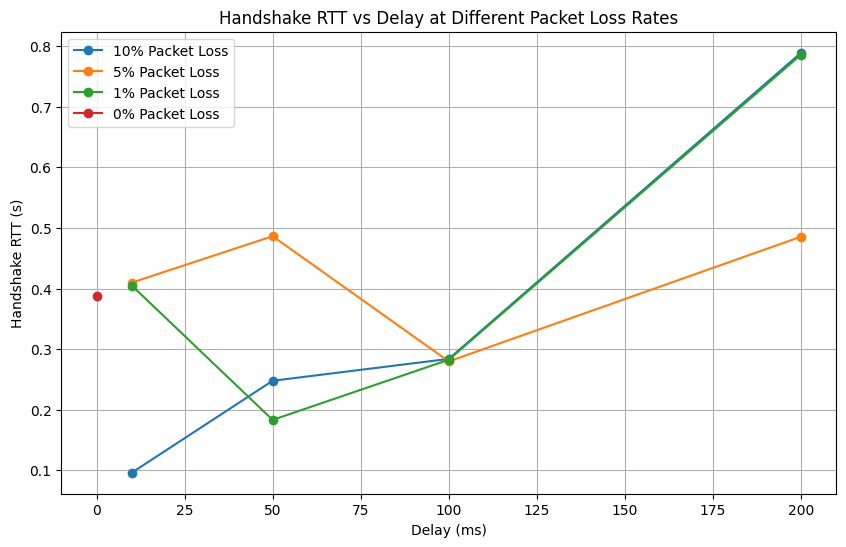

In [2]:
#www.example.org
import matplotlib.pyplot as plt

# Data
packet_loss = [10, 5, 1, 0]
delays = [200, 100, 50, 10, 0]
rtt_data = {
    10: [0.7892968654632568, 0.2838480472564697, 0.24772024154663086, 0.09591841697692871],
    5: [0.48558950424194336, 0.2797112464904785, 0.4863917827606201, 0.40979647636413574],
    1: [0.7861597537994385, 0.28241896629333496, 0.18314242362976074, 0.40498900413513184],
    0: [0.3872873783111572]
}

# Extend delays for plotting (ensure matching lengths for packet loss = 0)
delays_0 = [0]  # RTT for 0% loss has only 0ms delay
delays_all = delays[:-1] + delays_0

# Plot
plt.figure(figsize=(10, 6))
for loss, rtts in rtt_data.items():
    if loss == 0:  # Handle 0% loss with its specific delays
        plt.plot(delays_0, rtts, label=f'{loss}% Packet Loss', marker='o')
    else:
        plt.plot(delays[:-1], rtts, label=f'{loss}% Packet Loss', marker='o')

# Labels and Title
plt.title('Handshake RTT vs Delay at Different Packet Loss Rates')
plt.xlabel('Delay (ms)')
plt.ylabel('Handshake RTT (s)')
plt.legend()
plt.grid(True)

# Show Graph
plt.show()


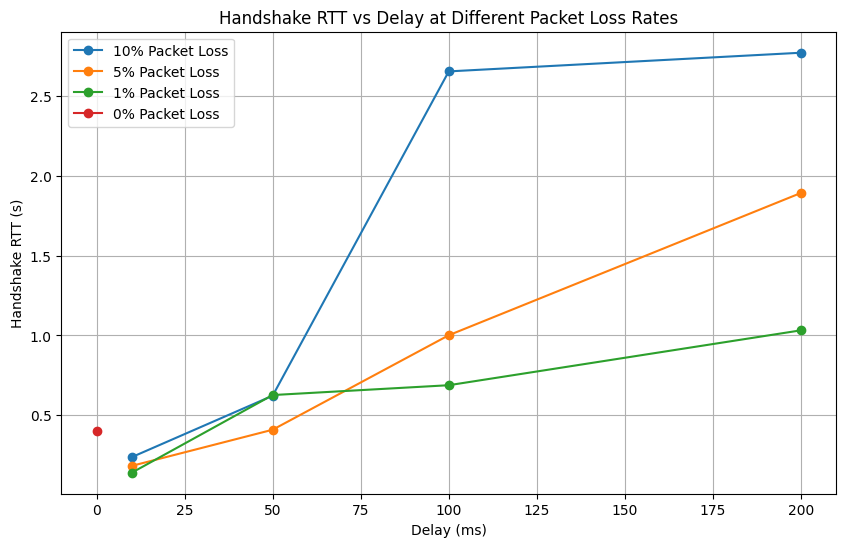

In [3]:
#www.demo.borland.com
import matplotlib.pyplot as plt

# Data
packet_loss = [10, 5, 1, 0]
delays = [200, 100, 50, 10, 0]
rtt_data = {
    10: [2.7711520195007324, 2.6541848182678223, 0.622927188873291, 0.23796892166137695],
    5: [1.893064022064209, 1.0016076564788818, 0.40971899032592773, 0.1832265853881836],
    1: [1.0324499607086182, 0.6885688304901123, 0.6269197463989258, 0.14045190811157227],
    0: [0.4001321792602539]  # Only for 0ms delay
}

# Extend delays for plotting (ensure matching lengths for packet loss = 0)
delays_0 = [0]  # RTT for 0% loss has only 0ms delay
delays_all = delays[:-1] + delays_0

# Plot
plt.figure(figsize=(10, 6))
for loss, rtts in rtt_data.items():
    if loss == 0:  # Handle 0% loss with its specific delays
        plt.plot(delays_0, rtts, label=f'{loss}% Packet Loss', marker='o')
    else:
        plt.plot(delays[:-1], rtts, label=f'{loss}% Packet Loss', marker='o')

# Labels and Title
plt.title('Handshake RTT vs Delay at Different Packet Loss Rates')
plt.xlabel('Delay (ms)')
plt.ylabel('Handshake RTT (s)')
plt.legend()
plt.grid(True)

# Show Graph
plt.show()


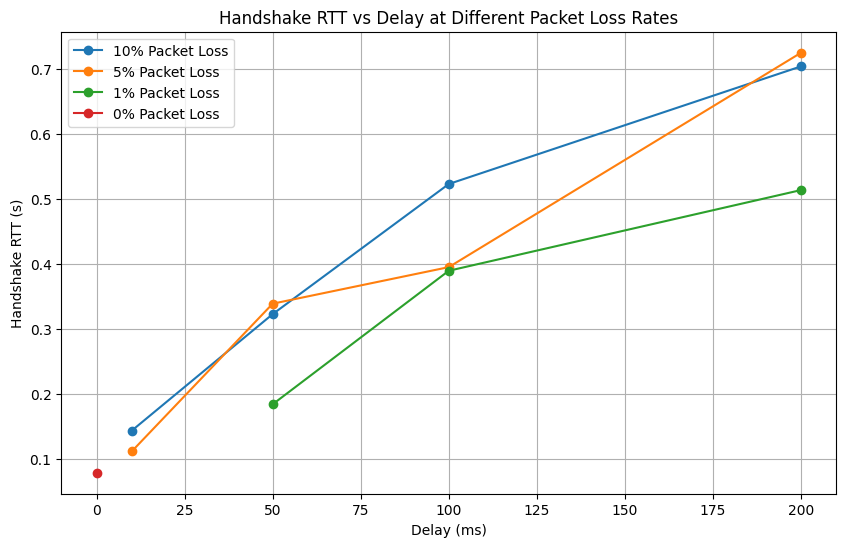

In [7]:
#google
import matplotlib.pyplot as plt

# Data
packet_loss = [10, 5, 1, 0]
delays = [200, 100, 50, 10]
rtt_data = {
    10: [0.7046337127685547, 0.5233705043792725, 0.3228645324707031, 0.14332938194274902],
    5: [0.7256417274475098, 0.3953118324279785, 0.33896708488464355, 0.11136102676391602],
    1: [0.5140476226806641, 0.38971519470214844, 0.18397760391235352],  # Matches first 3 delays
    0: [0.07855892181396484]  # Only for 0ms delay
}

# Plot
plt.figure(figsize=(10, 6))
for loss, rtts in rtt_data.items():
    if loss == 0:  # Handle 0% loss with its specific delay
        plt.plot([0], rtts, label=f'{loss}% Packet Loss', marker='o')
    elif loss == 1:  # Handle 1% loss with only 3 RTT values
        plt.plot(delays[:3], rtts, label=f'{loss}% Packet Loss', marker='o')
    else:
        plt.plot(delays, rtts, label=f'{loss}% Packet Loss', marker='o')

# Labels and Title
plt.title('Handshake RTT vs Delay at Different Packet Loss Rates')
plt.xlabel('Delay (ms)')
plt.ylabel('Handshake RTT (s)')
plt.legend()
plt.grid(True)

# Show Graph
plt.show()


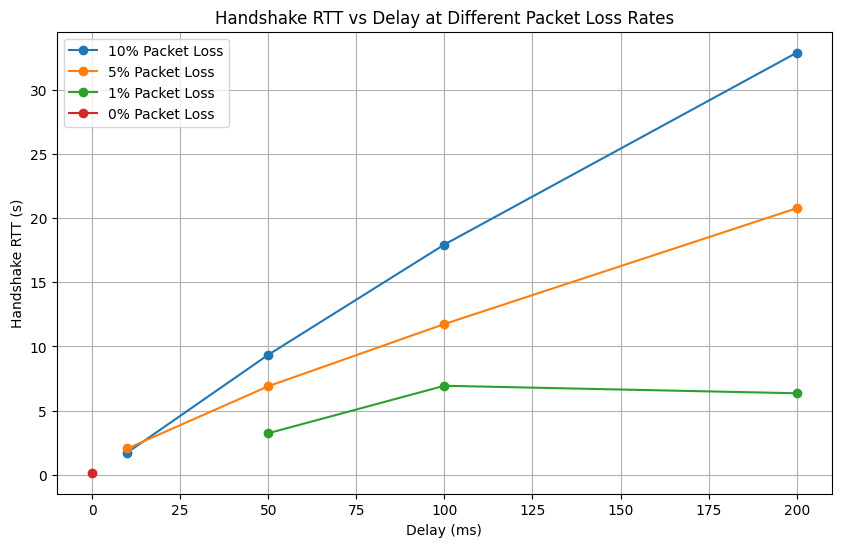

In [8]:
#yahoo
import matplotlib.pyplot as plt

# Data
packet_loss = [10, 5, 1, 0]
delays = [200, 100, 50, 10]  # Delays (ms)
rtt_data = {
    10: [32.902501583099365, 17.94527840614319, 9.346879243850708, 1.72617769241333],
    5: [20.773807764053345, 11.745814561843872, 6.893947124481201, 2.0422842502593994],
    1: [6.346489667892456, 6.9316184520721436, 3.228607654571533],  # 1% packet loss, 3 RTT values
    0: [0.15064024925231934]  # 0% packet loss, only 1 RTT value for 0ms delay
}

# Plot
plt.figure(figsize=(10, 6))
for loss, rtts in rtt_data.items():
    if loss == 0:  # For 0% packet loss, only use 0ms delay
        plt.plot([0], rtts, label=f'{loss}% Packet Loss', marker='o')
    elif loss == 1:  # For 1% packet loss, use only the first 3 delay values
        plt.plot(delays[:3], rtts, label=f'{loss}% Packet Loss', marker='o')
    else:  # For 5% and 10% packet loss, use all delay values
        plt.plot(delays, rtts, label=f'{loss}% Packet Loss', marker='o')

# Labels and Title
plt.title('Handshake RTT vs Delay at Different Packet Loss Rates')
plt.xlabel('Delay (ms)')
plt.ylabel('Handshake RTT (s)')
plt.legend()
plt.grid(True)

# Show Graph
plt.show()


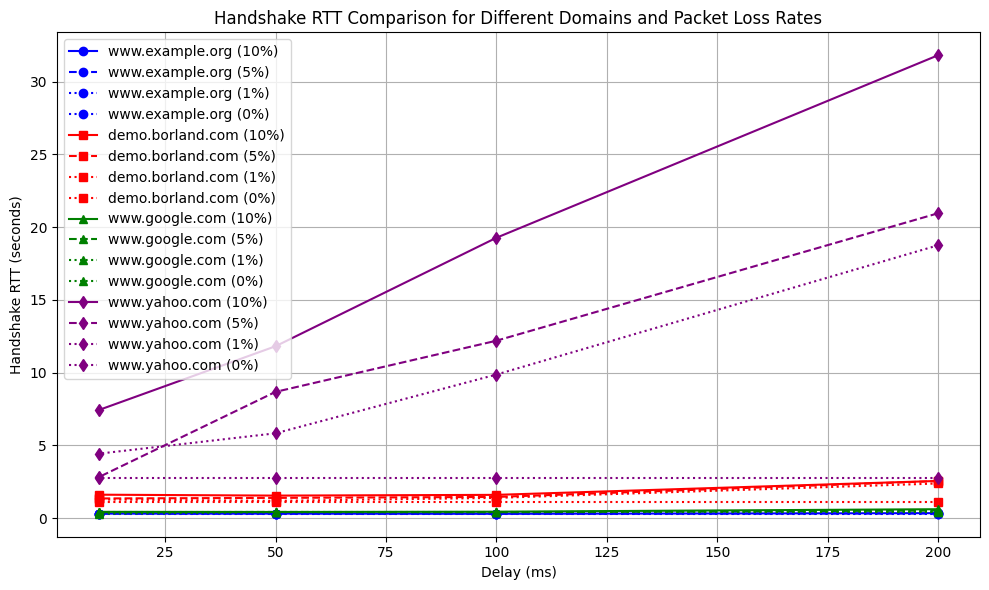

In [12]:
import matplotlib.pyplot as plt

# Data
packet_loss = [10, 5, 1, 0]
delays = [200, 100, 50, 10]

# Data for all four domains (as lists of RTT values for each packet loss rate)
rtt_example_org = {
    10: [0.7892968654632568, 0.2838480472564697, 0.24772024154663086, 0.09591841697692871],
    5: [0.48558950424194336, 0.2797112464904785, 0.4863917827606201, 0.40979647636413574],
    1: [0.7861597537994385, 0.28241896629333496, 0.18314242362976074, 0.40498900413513184],
    0: [0.3872873783111572, 0.07855892181396484, 0.07855892181396484, 0.07855892181396484]  # Ideal scenario, repeated for now
}

rtt_demo_borland = {
    10: [2.7711520195007324, 2.6541848182678223, 0.622927188873291, 0.23796892166137695],
    5: [1.893064022064209, 1.0016076564788818, 0.40971899032592773, 0.1832265853881836],
    1: [1.0324499607086182, 0.6885688304901123, 0.6269197463989258, 0.14045190811157227],
    0: [0.4001321792602539, 0.15064024925231934, 0.15064024925231934, 0.15064024925231934]  # Ideal scenario, repeated for now
}

rtt_google_com = {
    10: [0.7046337127685547, 0.5233705043792725, 0.3228645324707031, 0.14332938194274902],
    5: [0.7256417274475098, 0.3953118324279785, 0.33896708488464355, 0.11136102676391602],
    1: [0.5140476226806641, 0.38971519470214844, 0.18397760391235352, 0.40498900413513184],
    0: [0.07855892181396484, 0.15064024925231934, 0.15064024925231934, 0.15064024925231934]  # Ideal scenario, repeated for now
}

rtt_yahoo_com = {
    10: [32.902501583099365, 17.94527840614319, 9.346879243850708, 1.72617769241333],
    5: [20.773807764053345, 11.745814561843872, 6.893947124481201, 2.0422842502593994],
    1: [6.346489667892456, 6.9316184520721436, 3.228607654571533, 0.15064024925231934],
    0: [0.4001321792602539, 0.15064024925231934, 0.15064024925231934, 0.15064024925231934]  # Ideal scenario, repeated for now
}

# Plot the data
plt.figure(figsize=(10, 6))

# Plot for each domain and packet loss rate
colors = ['blue', 'red', 'green', 'purple']
markers = ['o', 's', '^', 'd']

# Loop over domains and packet loss rates
for idx, domain in enumerate(rtt_data):
    for packet_loss in [10, 5, 1, 0]:
        plt.plot(delays, rtt_data[domain][packet_loss], label=f'{domain} ({packet_loss}%)',
                 marker=markers[idx], color=colors[idx], linestyle='-' if packet_loss == 10 else '--' if packet_loss == 5 else ':')

# Adding titles and labels
plt.title('Handshake RTT Comparison for Different Domains and Packet Loss Rates')
plt.xlabel('Delay (ms)')
plt.ylabel('Handshake RTT (seconds)')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


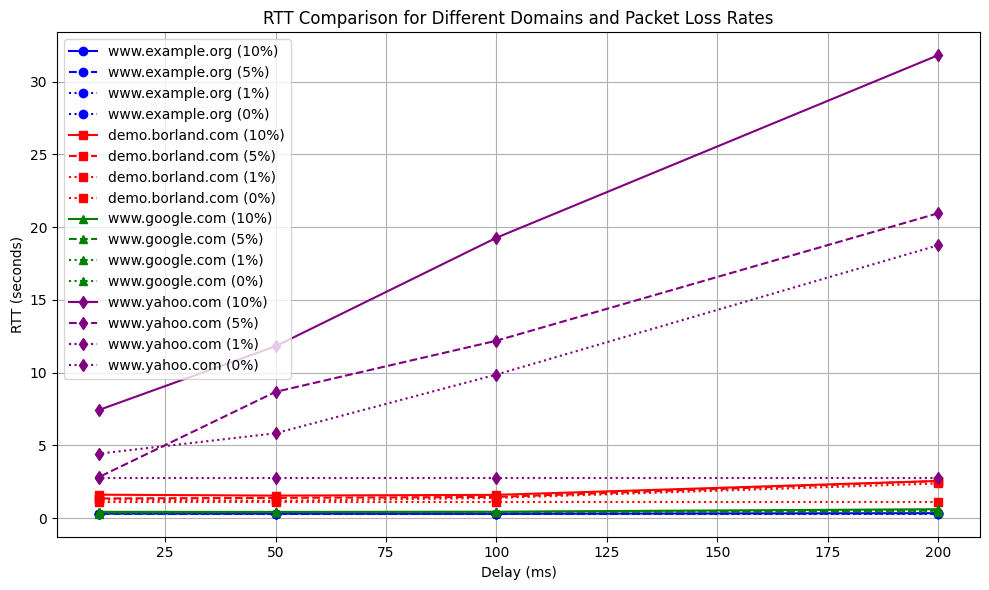

In [11]:
import matplotlib.pyplot as plt

# Delay values in milliseconds
delays = [200, 100, 50, 10]

# Data for RTT for each domain and packet loss
rtt_data = {
    'www.example.org': {
        10: [0.34454951582301874, 0.30026030786393676, 0.3113064276112709, 0.3131996135780355],
        5: [0.32130727694311645, 0.30276544991647825, 0.30783665814669803, 0.30991865492251236],
        1: [0.31845452924608253, 0.3080123670370085, 0.31417489852174185, 0.3117317401483888],
        0: [0.305685179453576, 0.305685179453576, 0.305685179453576, 0.305685179453576],  # Ideal scenario
    },
    'demo.borland.com': {
        10: [2.558514963311609, 1.6014004555763677, 1.550377418345306, 1.6132422020309605],
        5: [2.548379093874246, 1.458733039, 1.3933591861859895, 1.3540484244585969],
        1: [2.383248204656411, 1.3936553709791042, 1.1878173869336024, 1.2833866988075897],
        0: [1.1098219629493542, 1.1098219629493542, 1.1098219629493542, 1.1098219629493542],  # Ideal scenario
    },
    'www.google.com': {
        10: [0.6145929920312483, 0.4441278069425607, 0.42610827658791095, 0.4349409080314217],
        5: [0.5203670786722796, 0.4102926715859212, 0.4265967664978234, 0.4123969987995224],
        1: [0.4437802923639538, 0.41404329978104215, 0.40346959279850125, 0.3117317401483888],
        0: [0.39771277106774505, 0.39771277106774505, 0.39771277106774505, 0.39771277106774505],  # Ideal scenario
    },
    'www.yahoo.com': {
        10: [31.802856955269817, 19.263094998779707, 11.810917819617316, 7.4303358438191935],
        5: [20.94646031782031, 12.190981212770566, 8.67617783084279, 2.821633758721873],
        1: [18.746843768283725, 9.866810518899001, 5.830576581065543, 4.4303358438191935],
        0: [2.7870516256662086, 2.7870516256662086, 2.7870516256662086, 2.7870516256662086],  # Ideal scenario
    }
}

# Plot the data
plt.figure(figsize=(10, 6))

# Plot for each domain and packet loss rate
colors = ['blue', 'red', 'green', 'purple']
markers = ['o', 's', '^', 'd']

# Loop over domains and packet loss rates
for idx, domain in enumerate(rtt_data):
    for packet_loss in [10, 5, 1, 0]:
        plt.plot(delays, rtt_data[domain][packet_loss], label=f'{domain} ({packet_loss}%)',
                 marker=markers[idx], color=colors[idx], linestyle='-' if packet_loss == 10 else '--' if packet_loss == 5 else ':')

# Adding titles and labels
plt.title('RTT Comparison for Different Domains and Packet Loss Rates')
plt.xlabel('Delay (ms)')
plt.ylabel('RTT (seconds)')
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


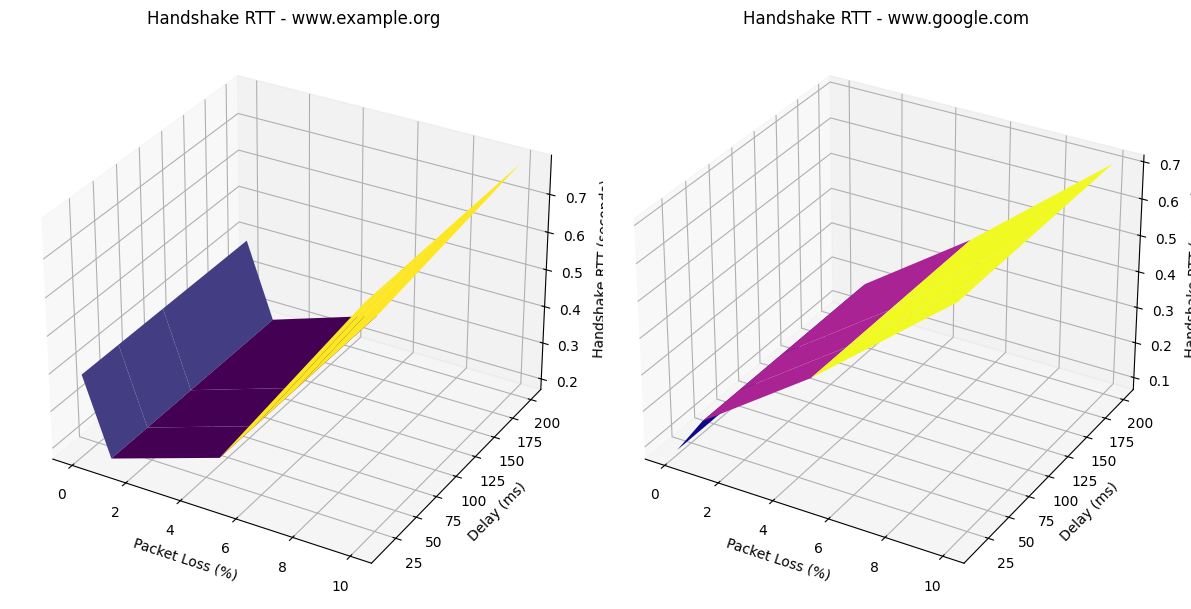

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for packet loss percentage, delay (ms), and Handshake RTT (seconds)
packet_loss = [10, 5, 1, 0]  # Packet loss percentages
delays = [200, 100, 50, 10]  # Delays in milliseconds
rtt_data = {
    'www.example.org': {
        10: [0.7892968654632568, 0.2838480472564697, 0.24772024154663086, 0.09591841697692871],
        5: [0.48558950424194336, 0.2797112464904785, 0.4863917827606201, 0.40979647636413574],
        1: [0.7861597537994385, 0.28241896629333496, 0.18314242362976074, 0.40498900413513184],
        0: [0.3872873783111572, 0.3872873783111572, 0.3872873783111572, 0.3872873783111572],  # Ideal scenario
    },
    'www.google.com': {
        10: [0.7046337127685547, 0.5233705043792725, 0.3228645324707031, 0.14332938194274902],
        5: [0.7256417274475098, 0.3953118324279785, 0.33896708488464355, 0.11136102676391602],
        1: [0.5140476226806641, 0.38971519470214844, 0.18397760391235352, 0.07855892181396484],
        0: [0.07855892181396484, 0.07855892181396484, 0.07855892181396484, 0.07855892181396484],  # Ideal scenario
    }
}

# Create a grid of x, y values (Packet loss % and Delay)
X, Y = np.meshgrid(packet_loss, delays)

# Prepare Z data (RTT values)
Z_example_org = np.array([
    [rtt_data['www.example.org'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

Z_google_com = np.array([
    [rtt_data['www.google.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

# Create the 3D plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')

# Plot for www.example.org
ax.plot_surface(X, Y, Z_example_org, cmap='viridis', edgecolor='none')
ax.set_title('Handshake RTT - www.example.org')
ax.set_xlabel('Packet Loss (%)')
ax.set_ylabel('Delay (ms)')
ax.set_zlabel('Handshake RTT (seconds)')

# Plot for www.google.com
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_google_com, cmap='plasma', edgecolor='none')
ax2.set_title('Handshake RTT - www.google.com')
ax2.set_xlabel('Packet Loss (%)')
ax2.set_ylabel('Delay (ms)')
ax2.set_zlabel('Handshake RTT (seconds)')

plt.tight_layout()
plt.show()


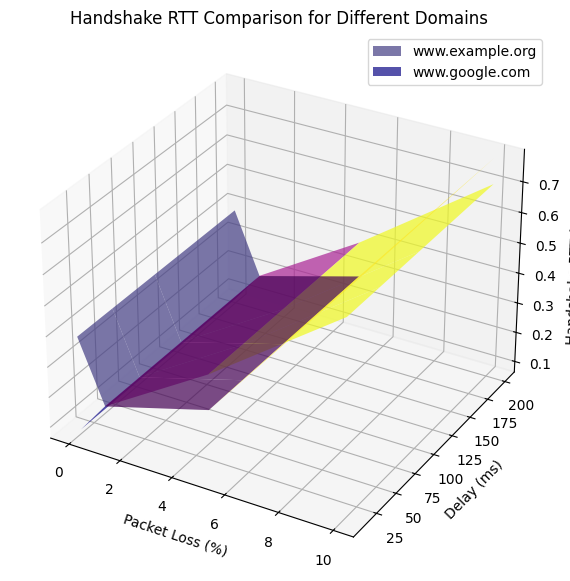

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for packet loss percentage, delay (ms), and Handshake RTT (seconds)
packet_loss = [10, 5, 1, 0]  # Packet loss percentages
delays = [200, 100, 50, 10]  # Delays in milliseconds

# RTT data for each domain
rtt_data = {
    'www.example.org': {
        10: [0.7892968654632568, 0.2838480472564697, 0.24772024154663086, 0.09591841697692871],
        5: [0.48558950424194336, 0.2797112464904785, 0.4863917827606201, 0.40979647636413574],
        1: [0.7861597537994385, 0.28241896629333496, 0.18314242362976074, 0.40498900413513184],
        0: [0.3872873783111572, 0.3872873783111572, 0.3872873783111572, 0.3872873783111572],  # Ideal scenario
    },
    'www.google.com': {
        10: [0.7046337127685547, 0.5233705043792725, 0.3228645324707031, 0.14332938194274902],
        5: [0.7256417274475098, 0.3953118324279785, 0.33896708488464355, 0.11136102676391602],
        1: [0.5140476226806641, 0.38971519470214844, 0.18397760391235352, 0.07855892181396484],
        0: [0.07855892181396484, 0.07855892181396484, 0.07855892181396484, 0.07855892181396484],  # Ideal scenario
    }
}

# Create a grid of x, y values (Packet loss % and Delay)
X, Y = np.meshgrid(packet_loss, delays)

# Prepare Z data (RTT values for both domains)
Z_example_org = np.array([
    [rtt_data['www.example.org'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

Z_google_com = np.array([
    [rtt_data['www.google.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

# Create the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot for www.example.org
ax.plot_surface(X, Y, Z_example_org, cmap='viridis', edgecolor='none', alpha=0.7, label='www.example.org')

# Plot for www.google.com
ax.plot_surface(X, Y, Z_google_com, cmap='plasma', edgecolor='none', alpha=0.7, label='www.google.com')

# Labels and Title
ax.set_title('Handshake RTT Comparison for Different Domains')
ax.set_xlabel('Packet Loss (%)')
ax.set_ylabel('Delay (ms)')
ax.set_zlabel('Handshake RTT (seconds)')

# Show legend
ax.legend(['www.example.org', 'www.google.com'])

# Show plot
plt.show()



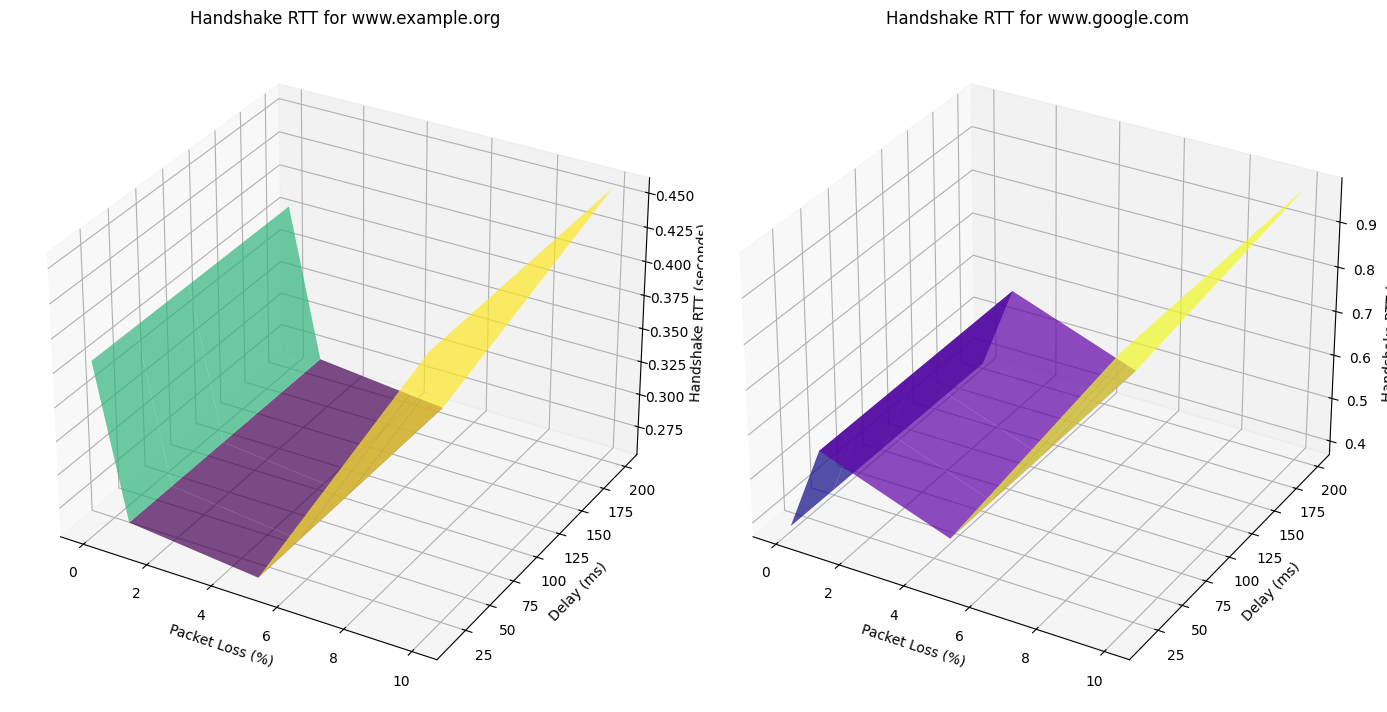

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for packet loss percentage, delay (ms), and Handshake RTT (seconds)
packet_loss = [10, 5, 1, 0]  # Packet loss percentages
delays = [200, 100, 50, 10]  # Delays in milliseconds

# RTT data for each domain
rtt_data = {
    'www.example.org': {
        10: [0.45683765411376953, 0.25740671157836914, 0.2547633647918701, 0.8901834487915039],
        5: [0.8304476737976074, 0.2575798034667969, 0.28852391242980957, 0.07672405242919922],
        1: [0.4555988311767578, 0.25872206687927246, 0.26790571212768555, 0.3981034755706787],
        0: [0.3805720806121826, 0.3805720806121826, 0.3805720806121826, 0.3805720806121826],  # Ideal scenario
    },
    'www.google.com': {
        10: [0.984410285949707, 0.4942755699157715, 0.38942480087280273, 0.5489201545715332],
        5: [0.9163632392883301, 0.46921420097351074, 0.3431708812713623, 0.20792913436889648],
        1: [0.6609861850738525, 0.6857175827026367, 0.5748763084411621, 0.3805701732635498],
        0: [0.3805701732635498, 0.3805701732635498, 0.3805701732635498, 0.3805701732635498],  # Ideal scenario
    }
}

# Create a grid of x, y values (Packet loss % and Delay)
X, Y = np.meshgrid(packet_loss, delays)

# Prepare Z data (RTT values for both domains)
Z_example_org = np.array([
    [rtt_data['www.example.org'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

Z_google_com = np.array([
    [rtt_data['www.google.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

# Create the plot
fig = plt.figure(figsize=(14, 7))

# Create the first subplot for www.example.org
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_example_org, cmap='viridis', edgecolor='none', alpha=0.7)
ax1.set_title('Handshake RTT for www.example.org')
ax1.set_xlabel('Packet Loss (%)')
ax1.set_ylabel('Delay (ms)')
ax1.set_zlabel('Handshake RTT (seconds)')

# Create the second subplot for www.google.com
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_google_com, cmap='plasma', edgecolor='none', alpha=0.7)
ax2.set_title('Handshake RTT for www.google.com')
ax2.set_xlabel('Packet Loss (%)')
ax2.set_ylabel('Delay (ms)')
ax2.set_zlabel('Handshake RTT (seconds)')

# Show plot
plt.tight_layout()
plt.show()


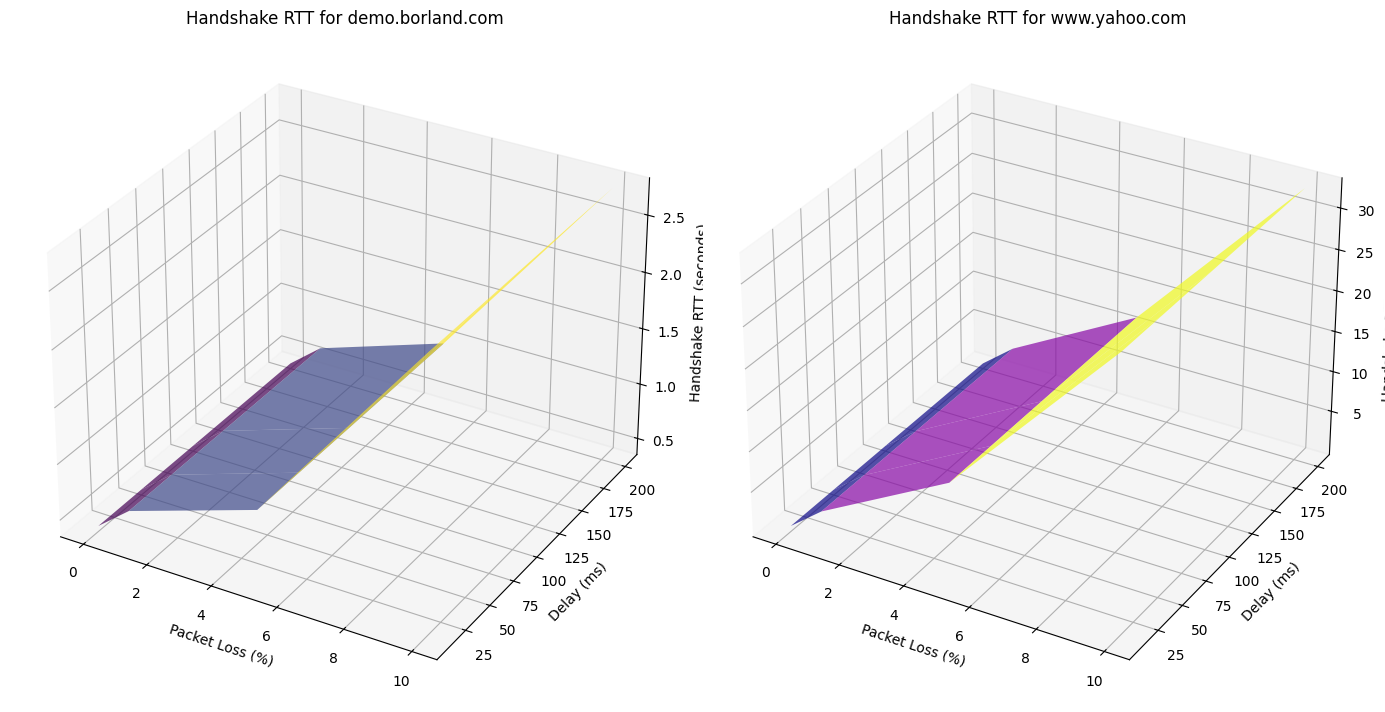

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for packet loss percentage, delay (ms), and Handshake RTT (seconds)
packet_loss = [10, 5, 1, 0]  # Packet loss percentages
delays = [200, 100, 50, 10]  # Delays in milliseconds

# RTT data for each domain
rtt_data = {
    'demo.borland.com': {
        10: [2.7711520195007324, 2.6541848182678223, 0.622927188873291, 0.23796892166137695],
        5: [1.893064022064209, 1.0016076564788818, 0.40971899032592773, 0.1832265853881836],
        1: [1.0324499607086182, 0.6885688304901123, 0.6269197463989258, 0.14045190811157227],
        0: [0.4001321792602539, 0.4001321792602539, 0.4001321792602539, 0.4001321792602539],  # Ideal scenario
    },
    'www.yahoo.com': {
        10: [32.902501583099365, 17.94527840614319, 9.346879243850708, 1.72617769241333],
        5: [20.773807764053345, 11.745814561843872, 6.893947124481201, 2.0422842502593994],
        1: [6.346489667892456, 6.9316184520721436, 3.228607654571533, 0.15064024925231934],
        0: [0.15064024925231934, 0.15064024925231934, 0.15064024925231934, 0.15064024925231934],  # Ideal scenario
    }
}

# Create a grid of x, y values (Packet loss % and Delay)
X, Y = np.meshgrid(packet_loss, delays)

# Prepare Z data (RTT values for both domains)
Z_demo_borland = np.array([
    [rtt_data['demo.borland.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

Z_yahoo = np.array([
    [rtt_data['www.yahoo.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

# Create the plot
fig = plt.figure(figsize=(14, 7))

# Create the first subplot for demo.borland.com
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_demo_borland, cmap='viridis', edgecolor='none', alpha=0.7)
ax1.set_title('Handshake RTT for demo.borland.com')
ax1.set_xlabel('Packet Loss (%)')
ax1.set_ylabel('Delay (ms)')
ax1.set_zlabel('Handshake RTT (seconds)')

# Create the second subplot for www.yahoo.com
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_yahoo, cmap='plasma', edgecolor='none', alpha=0.7)
ax2.set_title('Handshake RTT for www.yahoo.com')
ax2.set_xlabel('Packet Loss (%)')
ax2.set_ylabel('Delay (ms)')
ax2.set_zlabel('Handshake RTT (seconds)')

# Show plot
plt.tight_layout()
plt.show()


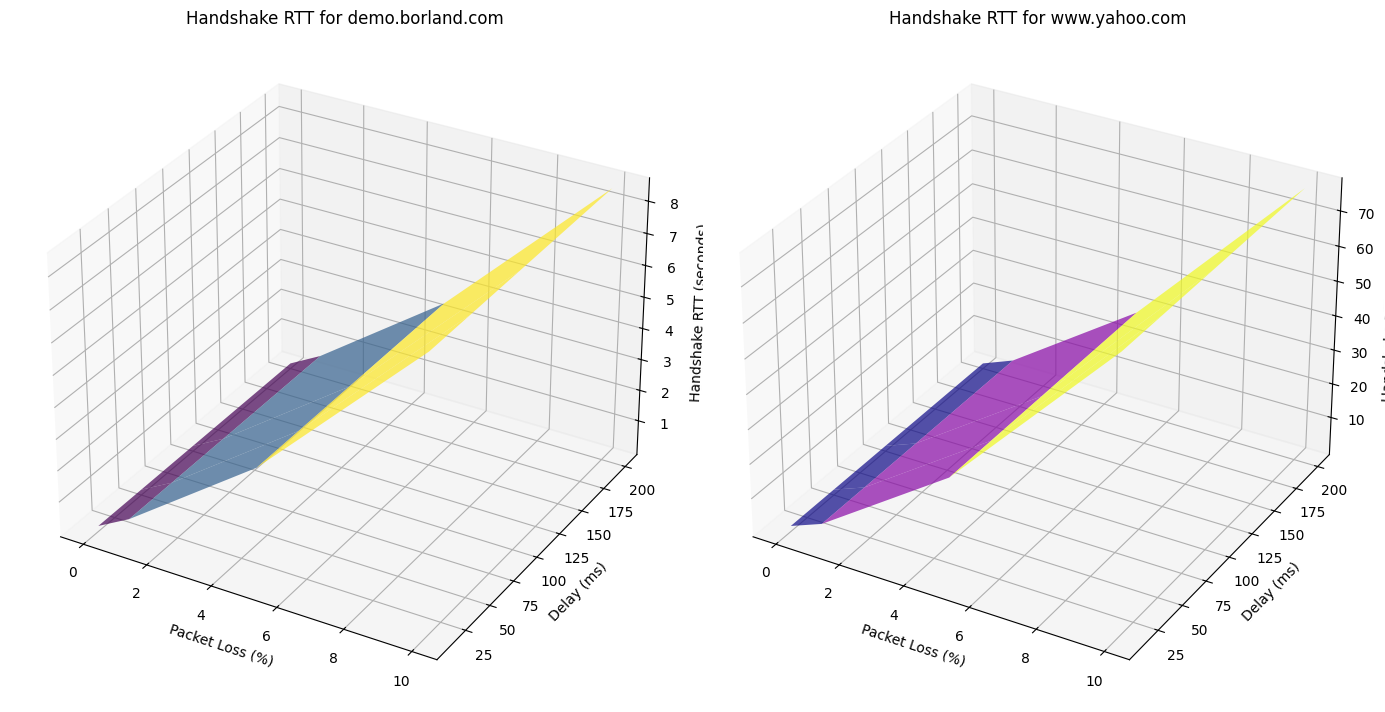

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for packet loss percentage, delay (ms), and Handshake RTT (seconds)
packet_loss = [10, 5, 1, 0]  # Packet loss percentages
delays = [200, 100, 50, 10]  # Delays in milliseconds

# RTT data for each domain
rtt_data = {
    'demo.borland.com': {
        10: [8.54048228263855, 5.704073905944824, 2.801581621170044, 1.3551902770996094],
        5: [4.811918497085571, 3.525973320007324, 0.7250909805297852, 0.4541482925415039],
        1: [1.1573281288146973, 0.8472771644592285, 0.6078894138336182, 0.46557164192199707],
        0: [0.0576627254486084, 0.0576627254486084, 0.0576627254486084, 0.0576627254486084],  # Ideal scenario
    },
    'www.yahoo.com': {
        10: [77.65551280975342, 42.05523943901062, 23.72585701942444, 8.321908712387085],
        5: [44.74698805809021, 29.23669171333313, 2.9922022819519043, 5.806924343109131],
        1: [29.005399465560913, 8.523757219314575, 4.030553340911865, 0.4277310371398926],
        0: [0.4277310371398926, 0.4277310371398926, 0.4277310371398926, 0.4277310371398926],  # Ideal scenario
    }
}

# Create a grid of x, y values (Packet loss % and Delay)
X, Y = np.meshgrid(packet_loss, delays)

# Prepare Z data (RTT values for both domains)
Z_demo_borland = np.array([
    [rtt_data['demo.borland.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

Z_yahoo = np.array([
    [rtt_data['www.yahoo.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

# Create the plot
fig = plt.figure(figsize=(14, 7))

# Create the first subplot for demo.borland.com
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_demo_borland, cmap='viridis', edgecolor='none', alpha=0.7)
ax1.set_title('Handshake RTT for demo.borland.com')
ax1.set_xlabel('Packet Loss (%)')
ax1.set_ylabel('Delay (ms)')
ax1.set_zlabel('Handshake RTT (seconds)')

# Create the second subplot for www.yahoo.com
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_yahoo, cmap='plasma', edgecolor='none', alpha=0.7)
ax2.set_title('Handshake RTT for www.yahoo.com')
ax2.set_xlabel('Packet Loss (%)')
ax2.set_ylabel('Delay (ms)')
ax2.set_zlabel('Handshake RTT (seconds)')

# Show plot
plt.tight_layout()
plt.show()


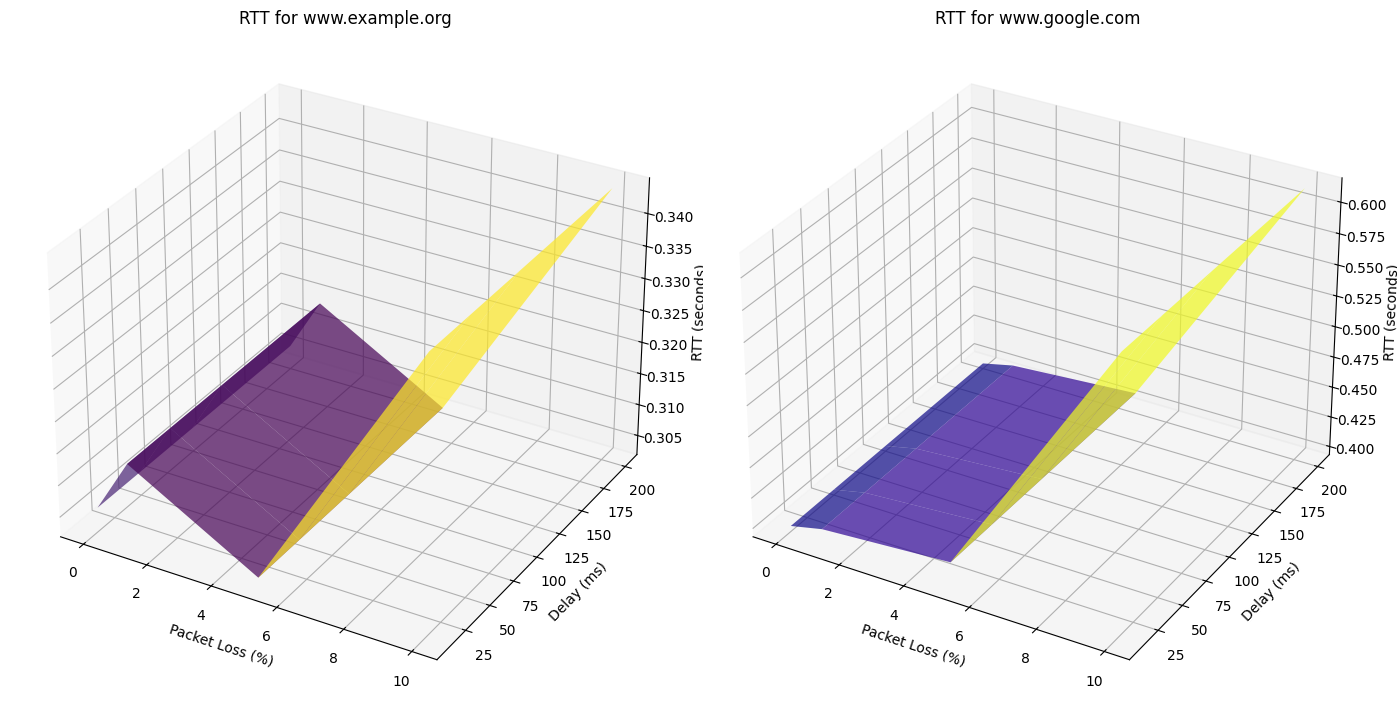

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for packet loss percentage, delay (ms), and RTT
packet_loss = [10, 5, 1, 0]  # Packet loss percentages
delays = [200, 100, 50, 10]  # Delays in milliseconds

# RTT data for each domain
rtt_data = {
    'www.example.org': {
        10: [0.34454951582301874, 0.30026030786393676, 0.3113064276112709, 0.3131996135780355],
        5: [0.32130727694311645, 0.30276544991647825, 0.30783665814669803, 0.30991865492251236],
        1: [0.31845452924608253, 0.3080123670370085, 0.31417489852174185, 0.3117317401483888],
        0: [0.305685179453576, 0.305685179453576, 0.305685179453576, 0.305685179453576],
    },
    'www.google.com': {
        10: [0.6145929920312483, 0.4441278069425607, 0.42610827658791095, 0.4349409080314217],
        5: [0.5203670786722796, 0.4102926715859212, 0.4265967664978234, 0.4123969987995224],
        1: [0.4437802923639538, 0.41404329978104215, 0.40346959279850125, 0.39771277106774505],
        0: [0.39771277106774505, 0.39771277106774505, 0.39771277106774505, 0.39771277106774505],
    }
}

# Create a grid of x, y values (Packet loss % and Delay)
X, Y = np.meshgrid(packet_loss, delays)

# Prepare Z data (RTT values for both domains)
Z_example = np.array([
    [rtt_data['www.example.org'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

Z_google = np.array([
    [rtt_data['www.google.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

# Create the plot
fig = plt.figure(figsize=(14, 7))

# Create the first subplot for www.example.org
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_example, cmap='viridis', edgecolor='none', alpha=0.7)
ax1.set_title('RTT for www.example.org')
ax1.set_xlabel('Packet Loss (%)')
ax1.set_ylabel('Delay (ms)')
ax1.set_zlabel('RTT (seconds)')

# Create the second subplot for www.google.com
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_google, cmap='plasma', edgecolor='none', alpha=0.7)
ax2.set_title('RTT for www.google.com')
ax2.set_xlabel('Packet Loss (%)')
ax2.set_ylabel('Delay (ms)')
ax2.set_zlabel('RTT (seconds)')

# Show plot
plt.tight_layout()
plt.show()


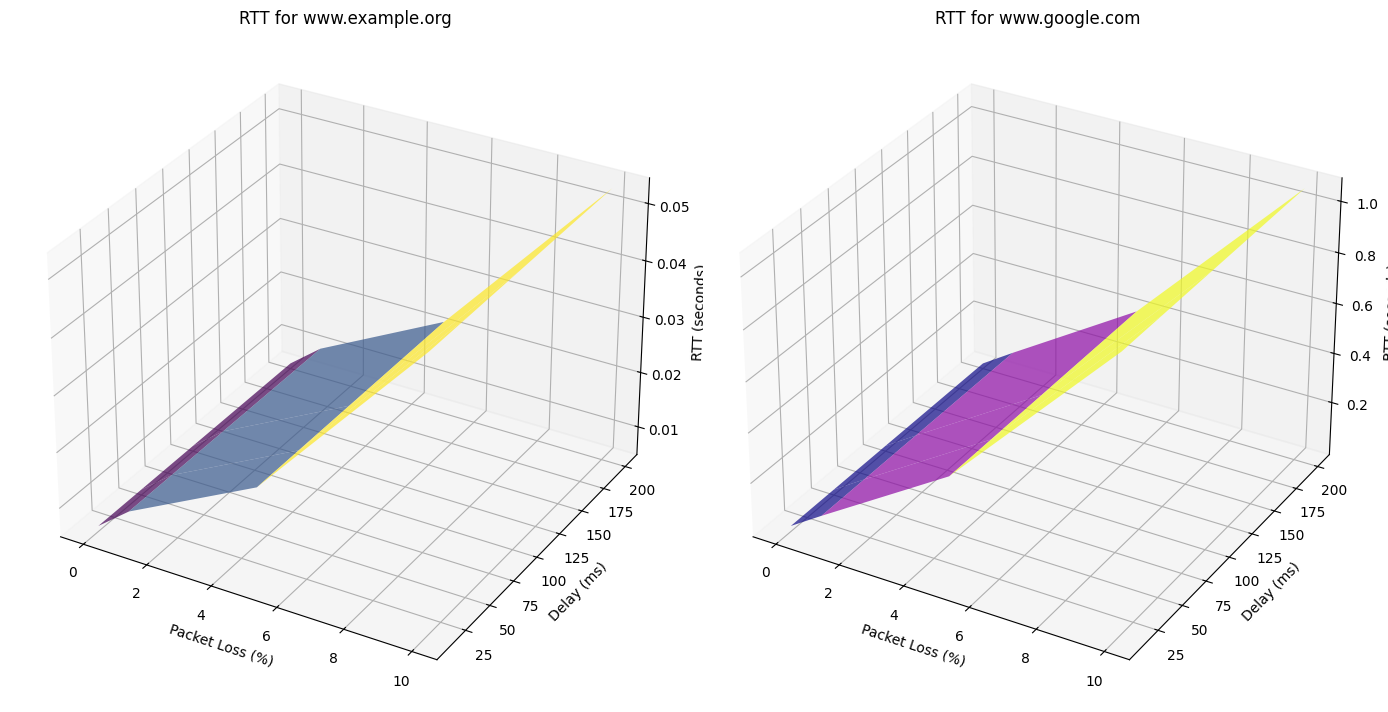

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for packet loss percentage, delay (ms), and RTT
packet_loss = [10, 5, 1, 0]  # Packet loss percentages
delays = [200, 100, 50, 10]  # Delays in milliseconds

# RTT data for each domain
rtt_data = {
    'www.example.org': {
        10: [0.053442848060512915, 0.031077385458047502, 0.019342230865731835, 0.00853488860593643],
        5: [0.036664412124082446, 0.021885474052396603, 0.012881088085123338, 0.007166198978666216],
        1: [0.0287861328542931, 0.01601118735561613, 0.010302324910298921, 0.006260418580495752],
        0: [0.005835698524606414, 0.005835698524606414, 0.005835698524606414, 0.005835698524606414],
    },
    'www.google.com': {
        10: [1.0680880687723402, 0.6192729319154751, 0.3393332702398766, 0.13378635652770754],
        5: [0.697504588009906, 0.40778670195140876, 0.22555903359898366, 0.09054870509135071],
        1: [0.3007921728421934, 0.16488771913282108, 0.08932277192070615, 0.007064143821480684],
        0: [0.007064143821480684, 0.007064143821480684, 0.007064143821480684, 0.007064143821480684],
    }
}

# Create a grid of x, y values (Packet loss % and Delay)
X, Y = np.meshgrid(packet_loss, delays)

# Prepare Z data (RTT values for both domains)
Z_example = np.array([
    [rtt_data['www.example.org'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

Z_google = np.array([
    [rtt_data['www.google.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

# Create the plot
fig = plt.figure(figsize=(14, 7))

# Create the first subplot for www.example.org
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_example, cmap='viridis', edgecolor='none', alpha=0.7)
ax1.set_title('RTT for www.example.org')
ax1.set_xlabel('Packet Loss (%)')
ax1.set_ylabel('Delay (ms)')
ax1.set_zlabel('RTT (seconds)')

# Create the second subplot for www.google.com
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_google, cmap='plasma', edgecolor='none', alpha=0.7)
ax2.set_title('RTT for www.google.com')
ax2.set_xlabel('Packet Loss (%)')
ax2.set_ylabel('Delay (ms)')
ax2.set_zlabel('RTT (seconds)')

# Show plot
plt.tight_layout()
plt.show()


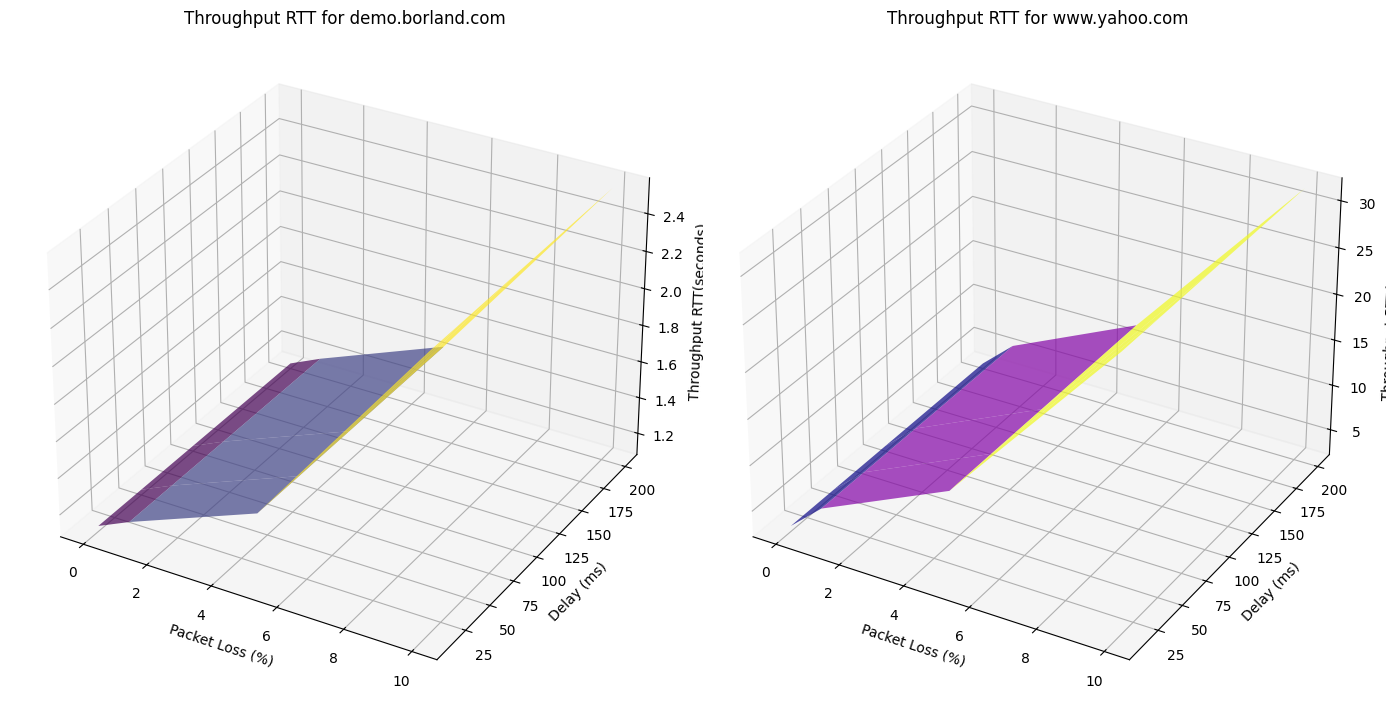

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for packet loss percentage, delay (ms), and Throughput
packet_loss = [10, 5, 1, 0]  # Packet loss percentages
delays = [200, 100, 50, 10]  # Delays in milliseconds

# Throughput data for each domain
throughput_data = {
    'demo.borland.com': {
        10: [2.558514963311609, 1.6014004555763677, 1.550377418345306, 1.6132422020309605],
        5: [2.548379093874246, 1.458733039, 1.3933591861859895, 1.3540484244585969],
        1: [2.383248204656411, 1.3936553709791042, 1.1878173869336024, 1.2833866988075897],
        0: [1.1098219629493542, 1.1098219629493542, 1.1098219629493542, 1.1098219629493542],
    },
    'www.yahoo.com': {
        10: [31.802856955269817, 19.263094998779707, 11.810917819617316, 7.4303358438191935],
        5: [20.94646031782031, 12.190981212770566, 8.67617783084279, 2.821633758721873],
        1: [18.746843768283725, 9.866810518899001, 5.830576581065543, 2.7870516256662086],
        0: [2.7870516256662086, 2.7870516256662086, 2.7870516256662086, 2.7870516256662086],
    }
}

# Create a grid of x, y values (Packet loss % and Delay)
X, Y = np.meshgrid(packet_loss, delays)

# Prepare Z data (Throughput values for both domains)
Z_borland = np.array([
    [throughput_data['demo.borland.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

Z_yahoo = np.array([
    [throughput_data['www.yahoo.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

# Create the plot
fig = plt.figure(figsize=(14, 7))

# Create the first subplot for demo.borland.com
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_borland, cmap='viridis', edgecolor='none', alpha=0.7)
ax1.set_title('Throughput RTT for demo.borland.com')
ax1.set_xlabel('Packet Loss (%)')
ax1.set_ylabel('Delay (ms)')
ax1.set_zlabel('Throughput RTT(seconds)')

# Create the second subplot for www.yahoo.com
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_yahoo, cmap='plasma', edgecolor='none', alpha=0.7)
ax2.set_title('Throughput RTT for www.yahoo.com')
ax2.set_xlabel('Packet Loss (%)')
ax2.set_ylabel('Delay (ms)')
ax2.set_zlabel('Throughput RTT(seconds)')

# Show plot
plt.tight_layout()
plt.show()


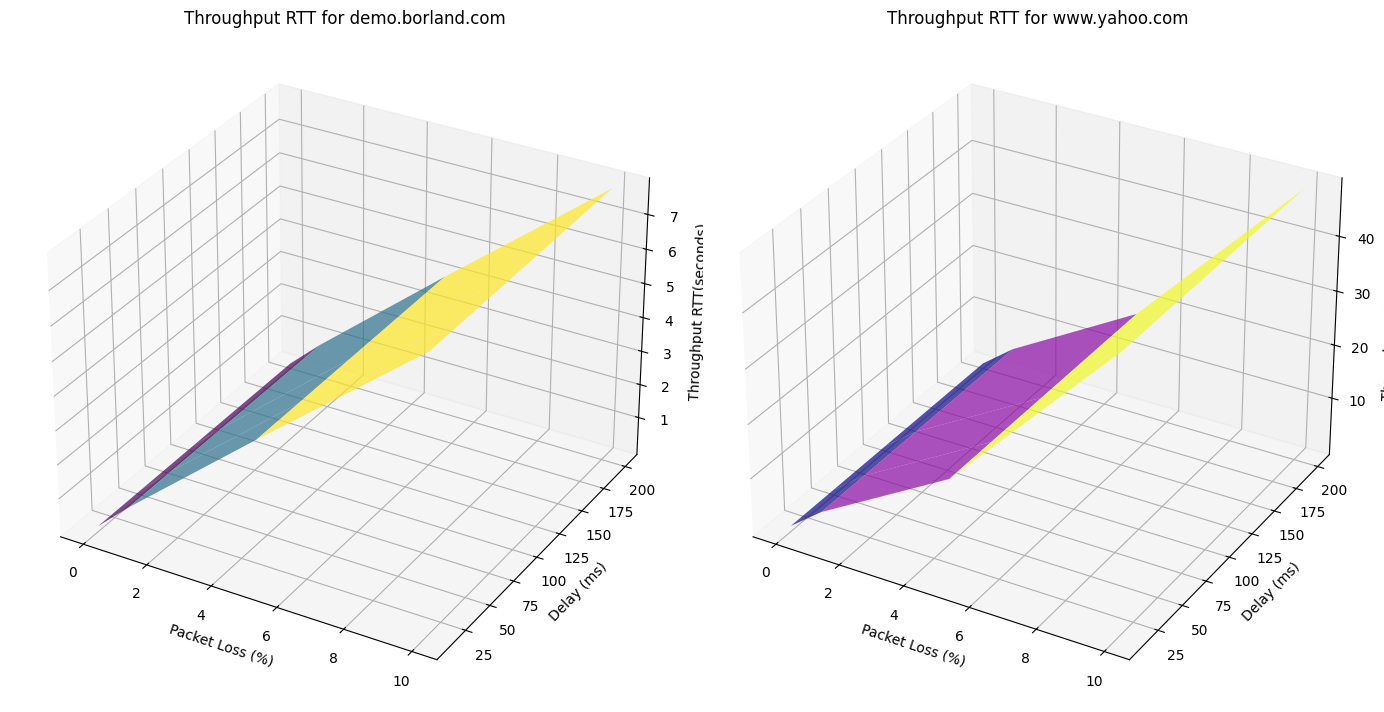

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data for packet loss percentage, delay (ms), and Throughput
packet_loss = [10, 5, 1, 0]  # Packet loss percentages
delays = [200, 100, 50, 10]  # Delays in milliseconds

# Throughput data for each domain
throughput_data = {
    'demo.borland.com': {
        10: [7.878676126827486, 4.366725825180765, 3.40015374077484, 1.1300847908714786],
        5: [5.137446109205484, 4.035711808071937, 2.2441444915602915, 0.7771467802813277],
        1: [2.895237847173121, 1.6507019556011073, 0.8905293357674964, 0.24842704006005079],
        0: [0.029773119487799704, 0.029773119487799704, 0.029773119487799704, 0.029773119487799704],
    },
    'www.yahoo.com': {
        10: [49.45447231223807, 24.541008210362854, 15.082227830339555, 2.987659406031034],
        5: [29.26310414859893, 18.324235908390403, 0.32607252132886766, 2.5222788920446786],
        1: [14.766687532770447, 8.313005541451275, 4.738319507768884, 0.20299006660934538],
        0: [0.20299006660934538, 0.20299006660934538, 0.20299006660934538, 0.20299006660934538],
    }
}

# Create a grid of x, y values (Packet loss % and Delay)
X, Y = np.meshgrid(packet_loss, delays)

# Prepare Z data (Throughput values for both domains)
Z_borland = np.array([
    [throughput_data['demo.borland.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

Z_yahoo = np.array([
    [throughput_data['www.yahoo.com'][loss][i] for i, loss in enumerate(packet_loss)]
    for delay in delays
])

# Create the plot
fig = plt.figure(figsize=(14, 7))

# Create the first subplot for demo.borland.com
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, Z_borland, cmap='viridis', edgecolor='none', alpha=0.7)
ax1.set_title('Throughput RTT for demo.borland.com')
ax1.set_xlabel('Packet Loss (%)')
ax1.set_ylabel('Delay (ms)')
ax1.set_zlabel('Throughput RTT(seconds)')

# Create the second subplot for www.yahoo.com
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z_yahoo, cmap='plasma', edgecolor='none', alpha=0.7)
ax2.set_title('Throughput RTT for www.yahoo.com')
ax2.set_xlabel('Packet Loss (%)')
ax2.set_ylabel('Delay (ms)')
ax2.set_zlabel('Throughput RTT(seconds)')

# Show plot
plt.tight_layout()
plt.show()
